In [19]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from datetime import datetime
from pandas import concat

from pandas import DataFrame
from pandas import Series

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

In [20]:


# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime(x, '%Y')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]



##Complete LSTM Example

Load the dataset from CSV file.
Transform the dataset to make it suitable for the LSTM model, including:
Transforming the data to a supervised learning problem.
Transforming the data to be stationary.
Transforming the data so that it has the scale -1 to 1.
Fitting a stateful LSTM network model to the training data.
Evaluating the static LSTM model on the test data.
Report the performance of the forecasts.
Some things to note about the example:

The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.
The complete example is listed below.

In [35]:
# load dataset
players = read_csv('bsb_ref.csv', parse_dates=[4], squeeze=True, date_parser=parser)
players = players.fillna(0)

# focusing on players after 1975
d1 = '1975-01-01'
date = datetime.strptime(d1, '%Y-%m-%d')
df_recent_players = players[players.year_ID >= date] #48k players

#reorder columns so date is first
df_recent_players = df_recent_players[['year_ID', 'name_common', 'age', 'mlb_ID', 'player_ID', 'team_ID', 'stint_ID',
                                       'lg_ID', 'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'pitcher', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg']]

ozzie_Smith_DF = df_recent_players.loc[df_recent_players['name_common'] == 'Ozzie Smith']

print(ozzie_Smith_DF.head())

         year_ID  name_common   age    mlb_ID  player_ID team_ID  stint_ID  \
90252 1978-01-01  Ozzie Smith  23.0  122439.0  smithoz01     SDP         1   
90253 1979-01-01  Ozzie Smith  24.0  122439.0  smithoz01     SDP         1   
90254 1980-01-01  Ozzie Smith  25.0  122439.0  smithoz01     SDP         1   
90255 1981-01-01  Ozzie Smith  26.0  122439.0  smithoz01     SDP         1   
90256 1982-01-01  Ozzie Smith  27.0  122439.0  smithoz01     STL         1   

      lg_ID     PA    G  ...  oppRpG_rep  pyth_exponent  pyth_exponent_rep  \
90252    NL  668.0  159  ...     3.87019          1.812              1.801   
90253    NL  649.0  156  ...     4.07843          1.828              1.827   
90254    NL  712.0  158  ...     3.87045          1.812              1.801   
90255    NL  507.0  110  ...     3.73275          1.787              1.783   
90256    NL  567.0  140  ...     3.92351          1.819              1.808   

       waa_win_perc  waa_win_perc_off  waa_win_perc_def  waa_w

        WAR
90252  3.25
90253  1.64
90254  5.07
90255  0.99
90256  5.03
90257  3.78
90258  4.98
90259  6.42
90260  5.58
90261  6.43
90262  6.60
90263  7.30
90264  3.62
90265  5.06
90266  5.10
90267  3.11
90268  2.10
90269 -0.73
90270  1.55
supervised_values:  18 [[ 0.   -1.61]
 [-1.61  3.43]
 [ 3.43 -4.08]
 [-4.08  4.04]
 [ 4.04 -1.25]
 [-1.25  1.2 ]
 [ 1.2   1.44]
 [ 1.44 -0.84]
 [-0.84  0.85]
 [ 0.85  0.17]
 [ 0.17  0.7 ]
 [ 0.7  -3.68]
 [-3.68  1.44]
 [ 1.44  0.04]
 [ 0.04 -1.99]
 [-1.99 -1.01]
 [-1.01 -2.83]
 [-2.83  2.28]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Year=1, Predicted=6.632459, Expected=0.990000
Year=2, Predicted=3.722684, Expected=5.030000
Year=3, Predicted=7.229143, Expected=3.780000
Year=4, Predicted=5.149249, Expected=4.980000
Year=5, Predicted=4.608409, Expected=6.420000
Year=6, Predicted=3.939865, Expected=5.580000
Year=7, Predicted=6.552739, Expected=6.430000
Year=8, Predicted=5.112337, Expected=6.600000
Year=9, Predicted=3.535480, Expected=7.300000
Year=10, Predicted=3.181404, Expected=3.620000
Year=11, Predicted=7.653459, Expected=5.060000
Year=12, Predicted=6.933165, Expected=5.100000
Year=13, Predicted=4.990590, Expected=3.110000
Year=14, Predicted=5.940435, Expected=2.100000
Year=15, Predicted=2.804854, Expected=-0.730000
Year=16, Predicted=1.982662, Expected=1.550000
Test RMSE: 2.611


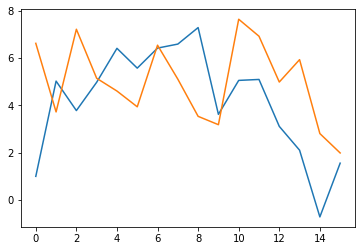

In [36]:
#data preprocessing to get LSTM working for player x
#based on past yrs of player's performance, predict future performance  of player x)

#cast all to same type float
ozzie_Smith_DF['G'] = ozzie_Smith_DF['G'].astype(float)
ozzie_Smith_DF['stint_ID'] = ozzie_Smith_DF['stint_ID'].astype(float)
ozzie_Smith_DF = ozzie_Smith_DF.drop(["team_ID", "lg_ID", "pitcher", "player_ID", "name_common"], axis=1)
ozzie_Smith_smallDF = ozzie_Smith_DF
ozzie_Smith_smallDF = ozzie_Smith_smallDF.drop(['year_ID', 'age', 'mlb_ID', 'stint_ID',
                                       'PA', 'G', 'Inn', 'runs_bat', 'runs_br', 'runs_dp', 'runs_field', 
                                       'runs_infield', 'runs_outfield', 'runs_catcher', 'runs_good_plays',
                                       'runs_defense', 'runs_position', 'runs_position_p', 'runs_replacement',
                                        'runs_above_rep', 'runs_above_avg', 'runs_above_avg_off', 'runs_above_avg_def',
                                       'WAA', 'WAA_off', 'WAA_def', 'WAR_def', 'WAR_off', 'WAR_rep',
                                       'salary', 'teamRpG', 'oppRpG', 'oppRpPA_rep', 'oppRpG_rep',
                                       'pyth_exponent', 'pyth_exponent_rep', 'waa_win_perc', 'waa_win_perc_off',
                                       'waa_win_perc_def', 'waa_win_perc_rep', 'OPS_plus', 'TOB_lg', 'TB_lg'], axis=1)

print(ozzie_Smith_smallDF)
# transform data to be stationary
raw_values = ozzie_Smith_smallDF.values
oneDim = np.stack(raw_values, axis =1)
raw_values = oneDim[0]
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
print("supervised_values: ", len(supervised_values), supervised_values)
train, test = supervised_values[0:-16], supervised_values[-16:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Year=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-16:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-16:], label='WAR')
pyplot.plot(predictions, label='Predicted War')
pyplot.show()
